In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import dask.array as da

from project.io import IntakeESMLoader
from project.plotting import plot_field
from project.util import stack_state, unstack_state
from project.eof import EOF, TwoStepEOF

In [237]:
ds = xr.open_dataset("/home/enkf6/dstiller/test_io_output.nc", chunks=dict(time=1))[
    ["zg500", "psl", "tas"]
]

/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/xarray/coding/times.py:832: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/disk/p/dstiller/.local/software/miniconda3/envs/enspred/lib/python3.11/site-packages/xarray/core/indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [238]:
ds

<xarray.Dataset>
Dimensions:             (time: 480, lat: 90, lon: 180)
Coordinates:
  * time                (time) object 7001-01-16 12:00:00 ... 7040-12-16 12:0...
  * lon                 (lon) float64 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
  * lat                 (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
    latitude_longitude  float64 ...
Data variables:
    zg500               (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    psl                 (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
    tas                 (time, lat, lon) float32 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>

In [243]:
data = ds["psl"].isel(time=slice(None, 100))
data = stack_state(data)
data -= data.mean(dim="time")
data

<xarray.DataArray '' (state: 16200, time: 100)>
dask.array<sub, shape=(16200, 100), dtype=float32, chunksize=(16200, 1), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) object 7001-01-16 12:00:00 ... 7009-04-16 00:0...
    latitude_longitude  float64 ...
  * state               (state) object MultiIndex
  * field               (state) object 'psl' 'psl' 'psl' ... 'psl' 'psl' 'psl'
  * lon                 (state) float64 0.0 0.0 0.0 0.0 ... 358.0 358.0 358.0
  * lat                 (state) float64 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    units:          Pa
    realm:          atmos
    regrid_method:  bilinear

In [244]:
eof = EOF(10)
eof.fit(data, EOFMethod.NUMPY)

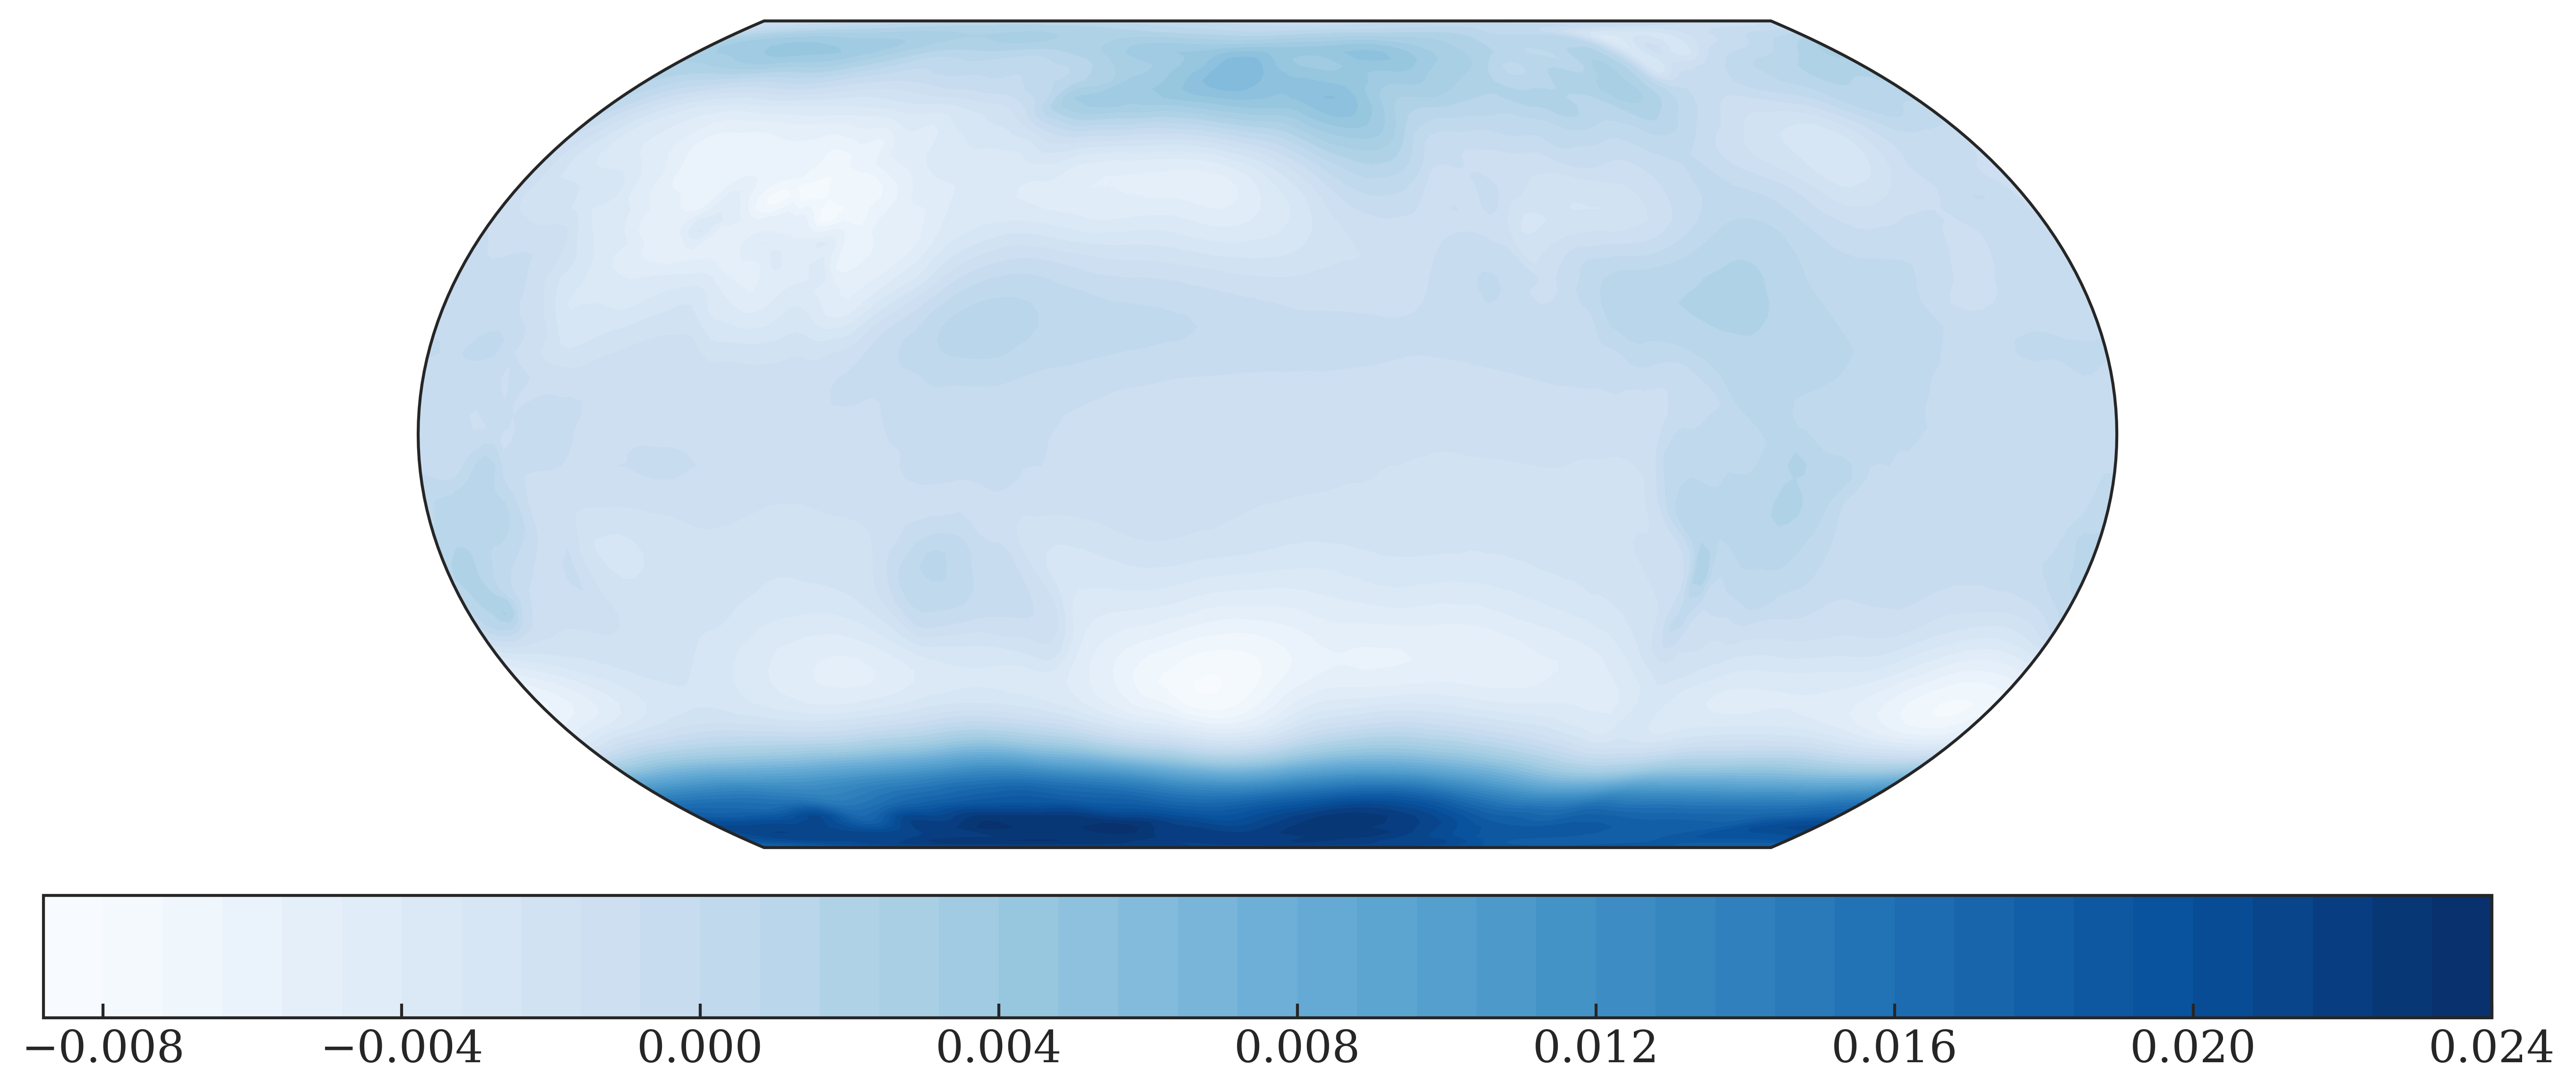

In [252]:
da = unstack_state(eof.get_component(1)).sel(field="psl").T
# da = np.isnan(ds["tos"].isel(time=3))
fig, ax = plt.subplots(
    subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=198))
)
plot_field(ax, da)

In [293]:
tseof = TwoStepEOF(10, 20)
tseof.fit(ds)

INFO:project.eof:Calculating field variances
INFO:project.eof:Detrending data
INFO:project.eof:Fitting EOF for zg500
INFO:project.eof:Fitting EOF for psl
INFO:project.eof:Fitting EOF for tas
INFO:project.eof:Fitting joint EOF


<xarray.DataArray '' (state: 30, time: 480)>
array([[-0.14687377, -0.1635025 , -0.10277879, ...,  0.01474621,
        -0.06065122, -0.13260396],
       [-0.00933873,  0.00192484,  0.00143459, ...,  0.04100609,
         0.03005095, -0.00489844],
       [-0.00050597,  0.0210823 ,  0.03895728, ..., -0.02083809,
        -0.01614993, -0.03732897],
       ...,
       [-0.07346395,  0.15799284,  0.11654473, ..., -0.08182839,
         0.04714565,  0.01097155],
       [ 0.16254033,  0.17431737, -0.02835759, ...,  0.00377679,
        -0.0821591 , -0.01629094],
       [-0.07069584,  0.03397991,  0.07935848, ..., -0.02133731,
        -0.11790274, -0.13651325]], dtype=float32)
Coordinates:
  * time                (time) object 7001-01-16 12:00:00 ... 7040-12-16 12:0...
    latitude_longitude  float64 nan
  * state               (state) object MultiIndex
  * field               (state) object 'zg500' 'zg500' 'zg500' ... 'tas' 'tas'
  * state_eof           (state) int64 0 1 2 3 4 5 6 7 8 9 ... 1 2 3 4 5 6 7 8 9